In [ ]:
!pip install kornia dm-pix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 4.4 MB/s eta 0:00:00


In [ ]:
import cv2 as cv
import dm_pix as pix
import csv
from matplotlib import pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from google.colab.patches import cv2_imshow
import imutils
import scipy as sci
from skimage.metrics import structural_similarity as calc_ssim
from itertools import permutations
import time
import kornia as korn

In [ ]:
image_test = cv.imread("/content/faustão-imagem.jpg")

# **Distortions Types**

## **Blur**
- Gaussian Blur
- Motion's Blur

### **Gaussian Blur**

In [ ]:
def gaussian_blur(image, sigma, kernel_size):
  return cv.GaussianBlur(image, (kernel_size,kernel_size), sigma)

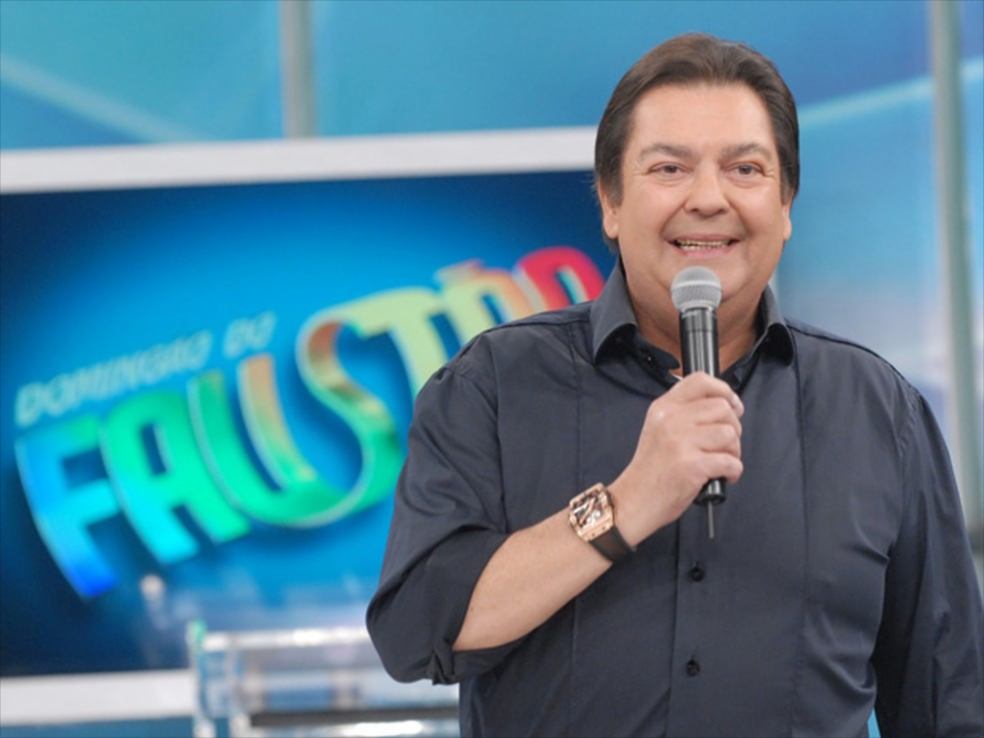

In [ ]:
def generate_gaussian_blur(image, sigmas = None, kernel_size = None):
  if sigmas is None:
    sigmas = [0.5, 1, 3, 7, 10]
    kernel_size = [11,11,11,11,11]
  images = []

  for i in range(len(sigmas)):
    images.append(gaussian_blur(image, sigmas[i], kernel_size[i]))

  return images

#cv2_imshow(generate_gaussian_blur(image_test)[3])

### Motion Blur

In [ ]:
def motion_blur(image, kernelsize):

  middle = kernelsize/2
  middle = int(middle)

  horizontalKernel = np.zeros((kernelsize, kernelsize))
  horizontalKernel = cv.line(horizontalKernel, pt1 = (0, middle), pt2 = (kernelsize, middle), color = 1)*1/kernelsize

  verticalKernel = np.zeros((kernelsize, kernelsize))
  verticalKernel = cv.line(verticalKernel, pt1 = (middle, 0) , pt2 = (middle, kernelsize) , color = 1)*1/kernelsize


  diagonalKernel = np.zeros((kernelsize, kernelsize))
  diagonalKernel = cv.line(diagonalKernel, pt1 = (0, 0) , pt2 = (kernelsize, kernelsize) , color = 1)*1/kernelsize

  vertical = cv.filter2D(image, -1, verticalKernel)
  horizontal = cv.filter2D(image, -1, horizontalKernel)
  diagonal = cv.filter2D(image, -1, diagonalKernel)

  return horizontal, vertical, diagonal

In [ ]:
def generate_motion_blur(image, kernels = None):
  if kernels is None:
    kernels = [2, 6, 9, 10, 12]

  images = []

  for i in range(len(kernels)):
    horizontal, vertical, diagonal = motion_blur(image, kernels[i])
    images.append(horizontal)
    images.append(vertical)
    images.append(diagonal)

  return images

#cv2_imshow(generate_motion_blur(image_test, [7])[0])


## **Noise**


*   Gausssian Noise
*   Uniform Noise
*   Speckle Noise
*   Poisson Noise
*   Salt and Pepper




### Gaussian Noise

In [ ]:
def gaussian_noise(image, mean=0, var=80):
  sigma = var ** 0.5
  shape = len(image.shape)
  if shape == 2:
    rows, cols = image.shape
  else:
    rows, cols, ch = image.shape

  gauss = np.random.normal(mean, sigma, (rows, cols, ch) if shape==3 else (rows,cols))
  noise = gauss + image

  noise = np.uint8(np.clip(noise,0,255))
  return noise


#gauss = gaussian_noise(image_test)
#cv2_imshow(gauss)

In [ ]:
def generate_gaussian_noise(image, mean_list=None, var_list=None):
  if var_list is None:
    var_list = [144,576,1296,2304,3600]
  if mean_list is None:
    mean_list = [0,0,0,0,0]

  noises = []
  assert len(mean_list) == len(var_list)
  for i in range(len(mean_list)):
    noises.append(gaussian_noise(image, mean_list[i], var_list[i]))

  return noises

#gaussians = generate_gaussian_noise(image_test)
#cv2_imshow(np.hstack(gaussians))

### Uniform Noise

In [ ]:
def uniform_noise(image, limit=150):
  mask_noise = np.random.randint(0,limit,image.shape)
  noise = mask_noise + image
  return np.uint8(np.clip(0,255,noise))#(cv.normalize(noise,None,0,255,cv.NORM_MINMAX))


#uniform = uniform_noise(image_test)
#cv2_imshow(uniform)

In [ ]:
def generate_uniform_noise(image, limit_list=None):
  if limit_list is None:
    limit_list = [30,60,90,120,150]

  noises = []
  for i in range(len(limit_list)):
    noises.append(uniform_noise(image, limit_list[i]))
  return noises

#uniforms = generate_uniform_noise(image_test)
#cv2_imshow(np.hstack(uniforms))

### Speckle Noise (Impulse Noise)

In [ ]:
def speckle_noise(image, mean=0, var=0.01):
  shape = len(image.shape)
  if shape == 2:
    rows, cols = image.shape
  else:
    rows,cols,ch = image.shape

  sigma = var**0.5
  gauss = np.random.normal(mean, sigma, (rows, cols,ch) if shape==3 else (rows,cols))
  noise = image + image*gauss

  noise = np.uint8(np.clip(0,255,noise))
  return noise

#speckle = speckle_noise(image_test)
#cv2_imshow(speckle)

In [ ]:
def generate_speckle_noise(image, mean_list=None, var_list=None):
  if var_list is None:
    var_list = [0.01,0.09,0.16,0.25,0.36]
  if mean_list is None:
    mean_list = [0,0,0,0,0]

  noises = []
  assert len(mean_list) == len(var_list)
  for i in range(len(mean_list)):
    noises.append(speckle_noise(image, mean_list[i], var_list[i]))

  return noises

#var_list = [0.01,0.09,0.16,0.25,0.36]
#mean_list = [0,0,0,0,0]
#speckles = generate_speckle_noise(image_test,mean_list,var_list)
#cv2_imshow(np.hstack(speckles))

### Poisson Noise

In [ ]:
def poisson_noise(image, bias=1):
  uni = len(np.unique(image)) * bias
  uni = (2 ** np.ceil(np.log2(uni)))
  noise = np.random.poisson(image*uni) / float(uni)
  noise = np.uint8(np.clip(noise, 0, 255))
  return noise

#poisson = poisson_noise(image_test)
#cv2_imshow(poisson)

In [ ]:
def generate_poisson_noise(image, bias_list=None):
  if bias_list is None:
    bias_list = [1,1/256,1/1024,1/2048,1/4096]

  noises = []
  for i in range(len(bias_list)):
    noises.append(poisson_noise(image, bias_list[i]))
  return noises

#bias_list = [1,1/256,1/1024,1/2048,1/4096]
#poissons = generate_poisson_noise(image_test, bias_list)
#cv2_imshow(np.hstack(poissons))

### Salt e Pepper Noise

In [ ]:
def sep_noise(image, prob_white=0.5, amount=0.004):
  shape = len(image.shape)
  if shape == 2:
    rows, cols = image.shape
  else:
    rows,cols,ch = image.shape

  noise = np.copy(image)

  num_salt = np.ceil(prob_white * amount * (image.shape[0]*image.shape[1]))
  coords = [np.random.randint(0,i-1,int(num_salt)) for i in image.shape[:-1]]
  for i in range(len(coords[0])):
    noise[coords[0][i]][coords[1][i]] = 255

  num_pepper = np.ceil((1-prob_white) * amount * (image.shape[0]*image.shape[1]))
  coords = [np.random.randint(0,i-1,int(num_pepper)) for i in image.shape[:-1]]
  for i in range(len(coords[0])):
    noise[coords[0][i]][coords[1][i]] = 0

  return noise

#saltepepper = sep_noise(image_test)
#cv2_imshow(saltepepper)

In [ ]:
def generate_sep_noise(image, prob_white_list = None, amount_list = None):
  if prob_white_list is None:
    prob_white_list = [0.5, 0.5, 0.5, 0.5, 0.2]
  if amount_list is None:
    amount_list = [0.0005, 0.001, 0.004, 0.008, 0.008]

  noises = []
  assert len(prob_white_list) == len(amount_list)
  for i in range(len(prob_white_list)):
    noises.append(sep_noise(image,prob_white_list[i],amount_list[i]))
  return noises

#saltepeppers = generate_sep_noise(image_test)
#cv2_imshow(np.hstack(saltepeppers))

## **Color Distortions**


*   Color Diffusion
*   Color Shift
*   Color Quantization
*   Color Saturation HSV
*   Color Saturation Lab



### RGB, XYZ, Lab Conversion

In [ ]:
def rgb2xyz(img):
    transformation_matrix = [[0.4124, 0.3576, 0.1805],
                             [0.2126, 0.7152, 0.0722],
                             [0.0193, 0.1192, 0.9505]]
    new_img = np.zeros(img.shape, dtype=np.float32)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img[i][j] = np.matmul(transformation_matrix,img[i][j])

    return new_img

def f_rgb2lab_m(epsilon, k, t):
  return np.where(t>epsilon, t**(1/3), ((k*t)+16)/116)

def f_lab2rgb_m(epsilon, k, t):
  return np.where(t>epsilon, t**3, ((t - 16/116)/(k/116)))

def rgb2lab(img):
    img_xyz = rgb2xyz(img)

    Xn = 95.0489
    Yn = 100
    Zn = 108.884

    e = 0.008856
    k = 903.3

    X,Y,Z = cv.split(img_xyz)


    L = 116 * f_rgb2lab_m(e,k,Y/Yn) - 16
    a = 500 * (f_rgb2lab_m(e,k,X/Xn) - f_rgb2lab_m(e,k,Y/Yn))
    b = 200 * (f_rgb2lab_m(e,k,Y/Yn) - f_rgb2lab_m(e,k,Z/Zn))

    img_Lab2 = cv.merge([L,a,b])
    return img_Lab2#np.uint8(np.round(img_Lab))

def tolab(img):
  img_f = np.float32(img)
  img_normalized = cv.normalize(img_f, None, 0,1, norm_type=cv.NORM_MINMAX)
  img_tensor = korn.utils.image_to_tensor(img_normalized)
  img_tensor_lab = korn.color.rgb_to_lab(img_tensor)
  img_lab = korn.utils.tensor_to_image(img_tensor_lab)
  return img_lab

def torgb(img):
  img_tensor = korn.utils.image_to_tensor(img)
  img_tensor_rgb = korn.color.lab_to_rgb(img_tensor)
  img_rgb = korn.utils.tensor_to_image(img_tensor_rgb)
  img_rgb_normalized = cv.normalize(img_rgb, None, 0,255, norm_type=cv.NORM_MINMAX)
  return np.uint8(img_rgb_normalized) #Reverte normalização entre [0,1]

def lab2rgb(img):
  L,a,b = cv.split(img)
  Xn = 95.0489
  Yn = 100
  Zn = 108.884

  Y = (L + 16) / 116
  X = a / 500 + Y
  Z = Y - b / 200

  e = 0.008856
  k = 903.3
  Y = f_lab2rgb_m(e,k,Y) * Yn
  X = f_lab2rgb_m(e,k,X) * Xn
  Z = f_lab2rgb_m(e,k,Z) * Zn

  img_XYZ = cv.merge([X,Y,Z])
  img_rgb = xyz2rgb(img_XYZ)

  return img_rgb#np.uint8(np.clip(0,255,np.round(img_rgb)))

def xyz2rgb(img):
  transformation_matrix = [[3.2405, -1.5371, -0.4985],
                           [-0.9693, 1.8706, 0.0416],
                           [0.0556, -0.2040, 1.0572]]

  rgb = np.zeros(img.shape, dtype=np.float32)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      rgb[i][j] = np.matmul(transformation_matrix, img[i][j])
  return rgb


### Color Diffusion

In [ ]:
def color_diffusion(img, kernel_size = 101, sigma=0):
  img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  #img_lab_lucas = rgb2lab(img_rgb)
  #cv2_imshow(img_lab_lucas)

  img_lab = tolab(img_rgb)
  L,a,b = cv.split(img_lab)
  #cv2_imshow(img_lab)

  a_blur = cv.GaussianBlur(a,(kernel_size,kernel_size),sigma)
  b_blur = cv.GaussianBlur(b,(kernel_size,kernel_size),sigma)
  diffused_lab = cv.merge([L, a_blur, b_blur])

  diffused_rgb = torgb(diffused_lab)
  diffused_bgr = cv.cvtColor(diffused_rgb, cv.COLOR_RGB2BGR)

  return np.uint8(diffused_bgr)

# diffusion = color_diffusion(image_test)
# cv2_imshow(diffusion)

In [ ]:
def generate_color_diffusion(image, kernel_size_list=None, sigma_list=None):
  if kernel_size_list is None:
    kernel_size_list = [9, 37, 55, 101, 209]
  if sigma_list is None:
    sigma_list = [0,0,0,0,0]

  noises = []
  assert len(kernel_size_list) == len(sigma_list)
  for i in range(len(sigma_list)):
    noises.append(color_diffusion(image, kernel_size_list[i], sigma_list[i]))

  return noises

#color_diffusions = generate_color_diffusion(image_test)
#cv2_imshow(np.hstack(color_diffusions))

### Color Shift

In [ ]:
def color_shift(img, tx=1, ty=8):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  gx = cv.Sobel(gray, ddepth=cv.CV_64F, dx=1, dy=0, ksize=29)
  gy = cv.Sobel(gray, ddepth=cv.CV_64F, dx=0, dy=1, ksize=29)

  magnitude = np.sqrt((gx**2)+(gy**2))
  magnitude = cv.normalize(cv.GaussianBlur(magnitude,(21,21),0),None,alpha=0,beta=1,norm_type=cv.NORM_MINMAX)#np.uint8(np.clip(0,255,magnitude))

  kernel = np.float32([[1,0,tx],
                      [0,1,ty]])

  b,g,r = cv.split(img)

  magnitude = cv.warpAffine(magnitude, kernel, (magnitude.shape[1], magnitude.shape[0]))
  green_t = cv.warpAffine(g, kernel, (g.shape[1], g.shape[0]))

  g_masked = (magnitude*green_t + ((1-magnitude)*g))
  g_masked = np.uint8(g_masked)
  #cv2_imshow(np.hstack([cv.normalize(magnitude,None,0,255,cv.NORM_MINMAX), green_t, g, g_masked]))
  color_shift = cv.merge([b,g_masked,r])
  return color_shift

#shift = color_shift(image_test)
#cv2_imshow(shift)

In [ ]:
def generate_color_shift(img, tx_list=None, ty_list=None):
  if tx_list is None:
    tx_list = [3, 5, 8, 10, 3]
  if ty_list is None:
    ty_list = [3, 5, 1, 2, 10]

  noises = []
  assert len(tx_list) == len(ty_list)
  for i in range(len(tx_list)):
    noises.append(color_shift(img, tx_list[i], ty_list[i]))

  return noises

#color_shifts = generate_color_shift(image_test)
#cv2_imshow(np.hstack(color_shifts))

### Color Quantization (faltando dithering)

In [ ]:
def k_means(img, k):
  vectorized = img.reshape((-1,3))
  vectorized = np.float32(vectorized)

  attempts = 3
  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 0.95)

  ret, label, center = cv.kmeans(vectorized,k,None,criteria,attempts,cv.KMEANS_PP_CENTERS)

  center = np.uint8(center)
  res = center[label.flatten()]
  result_image = res.reshape((img.shape))

  return result_image

def color_quantization(img, k=8):
  img_hsv = cv.cvtColor(img,cv.COLOR_BGR2LAB)
  kmeans = k_means(img_hsv, k)
  kmeans_bgr = cv.cvtColor(kmeans, cv.COLOR_LAB2BGR)

  return kmeans_bgr

#quantization = color_quantization(image_test,64)
#cv2_imshow(quantization)

In [ ]:
def generate_color_quantization(img, kcolor_list=None):
  if kcolor_list is None:
    kcolor_list = [64, 48, 32, 18, 8]

  distortions = []
  for i in range(len(kcolor_list)):
    distortions.append(color_quantization(img, kcolor_list[i]))
  return distortions

#quantization = generate_color_quantization(image_test)
#cv2_imshow(np.hstack(quantization))

### Color Saturation HSV

In [ ]:
def color_saturation_hsv(img, factor = 1.3):
  img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

  saturation_hsv = np.float32(np.copy(img_hsv))
  saturation_hsv[:,:,1] = img_hsv[:,:,1] * factor

  saturation_hsv = np.uint8(np.clip(0,255,np.round(saturation_hsv)))
  saturation_bgr = cv.cvtColor(saturation_hsv, cv.COLOR_HSV2BGR)

  return saturation_bgr#np.uint8(np.clip(0,255,np.round(saturation_bgr)))

#sat_hsv = color_saturation_hsv(image_test)
#cv2_imshow(sat_hsv)

In [ ]:
def generate_color_saturation_hsv(image, factor_list=None):
  if factor_list is None:
    factor_list = [0.4, 0.8, 1.4, 1.8, 2.1]

  distortions = []
  for i in range(len(factor_list)):
    distortions.append(color_saturation_hsv(image, factor_list[i]))

  return distortions

#saturations_hsv = generate_color_saturation_hsv(image_test)
#cv2_imshow(np.hstack(saturations_hsv))

### Color Saturation Lab

In [ ]:
def color_saturation_lab(img, factora=4, factorb=4):
  img_rgb = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  img_lab = rgb2lab(img_rgb)

  saturation_lab = np.copy(img_lab)
  saturation_lab[:,:,1] = img_lab[:,:,1] * factora
  saturation_lab[:,:,2] = img_lab[:,:,2] * factorb

  saturation_rgb = np.clip(np.round(lab2rgb(saturation_lab)), 0, 255)
  saturation_bgr = cv.cvtColor(saturation_rgb, cv.COLOR_RGB2BGR)

  return np.uint8(saturation_bgr)

#sat_lab = color_saturation_lab(image_test)
#cv2_imshow(sat_lab)

In [ ]:
def generate_color_saturation_lab(image, factora_list=None, factorb_list=None):
  if factora_list is None:
    factora_list = [1,1.5,2,3,4]
  if factorb_list is None:
    factorb_list = [1,1.5,2,3,4]

  distortions = []
  if len(factora_list) > len(factorb_list):
    factorb_list[len(factorb_list):len(factora_list)] = factora_list[len(factorb_list):]

  for i in range(len(factora_list)):
    distortions.append(color_saturation_lab(image, factora_list[i], factorb_list[i]))
  return distortions

#color_saturations = generate_color_saturation_lab(image_test)
#cv2_imshow(np.hstack(color_saturations))

## **Compression**


*   JPEG
*   JPEG2000



### JPEG

In [ ]:
def jpeg_compression(img, quality=10):
  _, buffer = cv.imencode('.jpg', img, [cv.IMWRITE_JPEG_QUALITY, quality])
  compressed_img = cv.imdecode(buffer, cv.IMREAD_COLOR)

  return compressed_img

#jpeg = jpeg_compression(image_test)
#cv2_imshow(jpeg)

In [ ]:
def generate_compression_jpeg(image, quality_list=None):
  if quality_list is None:
    quality_list = [95, 80, 50, 20, 10]

  compressions = []
  for i in range(len(quality_list)):
    compressions.append(jpeg_compression(image, quality_list[i]))

  return compressions


#compressions = generate_compression_jpeg(image_test)
#cv2_imshow(np.hstack(compressions))

###JPEG200

In [ ]:
def jpeg2000_compression(img, compressionRate=50):
  _, buffer = cv.imencode('.jp2', img, [cv.IMWRITE_JPEG2000_COMPRESSION_X1000, compressionRate])
  compressed_img = cv.imdecode(buffer, cv.IMREAD_COLOR)

  return compressed_img

#jpeg2 = jpeg2000_compression(image_test)
#cv2_imshow(jpeg2)

In [ ]:
def generate_compression_jpeg2000(image, compressionRate_list=None):
  if compressionRate_list is None:
    compressionRate_list = [1000, 500, 50, 10, 5]

  compressions = []
  for i in range(len(compressionRate_list)):
    compressions.append(jpeg2000_compression(image, compressionRate_list[i]))

  return compressions

#compressionRate_list = [1000, 500, 50, 10, 5]
#compressions2000 = generate_compression_jpeg2000(image_test)
#cv2_imshow(np.hstack(compressions2000))
#print(image_test.shape)

##**Warping**

- Inverting
- Shearing
- Elastic Deformation
- Bilinear Transformation
- Rotations

### **Inverting**

In [ ]:
def generate_invert_warp(image, bias=None):
  (H, L) = (image.shape[0], image.shape[1])


  initPoints = np.float32([[0, 0], [L-1, 0], [0, H-1], [L-1, H-1]])
  destPoints = np.float32([[L-1, 0], [0, 0], [L-1, H-1], [0, H-1]])

  MorphFunc = cv.getPerspectiveTransform(initPoints, destPoints)
  imageInverted = cv.warpPerspective(image, MorphFunc, dsize = (L, H))

  return [imageInverted]

#cv2_imshow(generate_invert_warp(image_test)[0])

### **Shearing**

In [ ]:
def shearing_warp(image, sx, sy):
  shearingMatrix = np.array([[1, sx, 0],
                             [sy, 1, 0]], dtype = np.float32)

  imageShear = cv.warpAffine(image, shearingMatrix, (image.shape[1],image.shape[0]), borderMode = cv.BORDER_CONSTANT)
  return imageShear


In [ ]:
def generate_shearing_warp(image, sx = None, sy = None):
  if (sx or sy) is None:
    H, L = image.shape[0:2]
    sx= [0.0002*L, 0.0002*L, 0.0003*L, 0.0002*L, 0.0003*L]
    sy = [0.0002*H, 0, 0.0002*H, 0.0002*H, 0.0003*H, 0.0003*H]

  images = []

  for i in range(len(sx)):
    images.append(shearing_warp(image, sx[i], sy[i]))

  return images

### **Elastic Deformation**



In [ ]:
def getTransform(H, L):
  #Create random translates
  (dy, dx) = np.random.uniform(-1, 1, (H, L)), np.random.uniform(-1, 1, (H, L))
  #Smooth
  (dy, dx) = cv.GaussianBlur(dy, (11, 11), 0), cv.GaussianBlur(dx, (11,11), 0)
  return dy, dx

def elastic_warp(image, alpha):

  #alpha [0, 1] -> janela de 10% da imagem, max

  if len(image.shape) == 3:
    dim = 3
  else:
    dim = 1

  H, L = image.shape[0:2]
  #Create a plan (x,y) -> x = [0, ..., L], y = [0...H]
  x, y = np.meshgrid(np.arange(L), np.arange(H))

  (dy, dx) = getTransform(H,L)

  #Normalizim, the distortion make each pixel "walk" in max 0.75%
  alpha_proportional = max(alpha * (H/150), alpha *(L/150))

  new_y = y + alpha_proportional*dy
  new_x = x + alpha_proportional*dx

  distorted_image = image.copy()

  for i in range(dim):
    distorted_image[:, :, i] = sci.ndimage.map_coordinates(image[:,:,i], [new_y, new_x], order=1, mode='reflect')

  return distorted_image.astype(np.uint8)

In [ ]:
def generate_elastic_warp(image, alphas = None):
  if alphas is None:
    alphas = [0.1, 0.3, 0.5, 0.7, 1]

  images = []
  for i in range(len(alphas)):
      images.append(elastic_warp(image,alphas[i]))

  return images

#elastics = generate_elastic_warp(image_test)
#cv2_imshow(elastics[4])

### **Bilinear_Interpolation**

In [ ]:
def bilinear_interpolation(image, scale):
  smallImage = cv.resize(image,  None, fx = scale, fy = scale, interpolation = cv.INTER_LINEAR)
  H, L = image.shape[0:2]
  imageStandart = cv.resize(smallImage, (L, H), interpolation = cv.INTER_LINEAR)
  return imageStandart


In [ ]:
def generate_bilinear_interpolation(image, scales = None):

  if scales is None:
    scales = [0.7, 0.6, 0.5, 0.4, 0.1]

  images = []

  for i in range(len(scales)):
    images.append(bilinear_interpolation(image, scales[i]))

  return images


#bilinear = generate_bilinear_interpolation(image_test)
#cv2_imshow(np.hstack(bilinear))


### **Rotations**

In [ ]:
def generate_rotations(image, bias = 0):
  imagesRotated = list()
  angle = 90
  for i in range(3):
    imagesRotated.append(imutils.rotate_bound(image, angle))
    angle += 90

  # Vector -> [Image rotated 90, Image rotated 180, Image rotated 270]
  return imagesRotated



## **Sharpness and Contrast**
- Unsharp Mask
- Contrast

### **Unsharp Mask**

In [ ]:
def unsharp_mask(image, intensity):
  #intensity -> [0, ..]

  bluredImage = cv.GaussianBlur(image, (15, 15), 0)
  dif = cv.subtract(image, bluredImage)
  sharpImage = cv.addWeighted(src1 = image, alpha = 1, src2 = dif, beta = intensity, gamma = 0)
  return sharpImage

In [ ]:
def generate_unsharp_mask(image, intensity = None):
  if intensity is None:
    intensity = [0.5, 1, 2, 3.5, 5]

  images = []

  for i in range(len(intensity)):
    images.append(unsharp_mask(image, intensity[i]))

  return images

#unsharp_masked = generate_unsharp_mask(image_test)
#cv2_imshow(np.hstack(unsharp_masked))

### **Contrast**

In [ ]:
def mult_contrast(image, intensity):
  # intensity > 1 -> Increscent contrast
  # intensity < 1 && intensity > 0 -> Decreasc contrast
  return cv.convertScaleAbs(image, alpha = intensity)

In [ ]:
def generate_mult_contrast(image, intensity = None):
  if intensity is None:
    intensity = [0.2, 0.5, 1.3, 1.5, 2]

  images = []

  for i in range(len(intensity)):
    images.append(mult_contrast(image, intensity[i]))

  return images

#contrasted = generate_mult_contrast(image_test)
#cv2_imshow(np.hstack(contrasted))

## **Brigthness**
- Change Brigthness value
- Local Changing Brigthness
- Random Local Changing Brigthness

### **Change Brigthness Global**

In [ ]:
def global_brigthness(image, intensity):
  assert (intensity >= -2 and intensity <= 2)
  #Intensity is in percentual
  B, G, R = cv.split(image)
  M = B.astype(np.uint32) + G.astype(np.uint32) + R.astype(np.uint32)
  mean_value = np.mean(M)

  sum = intensity * mean_value


  return cv.add(image, sum)


In [ ]:
def generate_global_brigthness(image, intensity = None):
  if intensity is None:
    intensity = [-0.4,  -0.2, 0.1, 0.2, 0.3]


  images = []

  for i in range(len(intensity)):
    images.append(global_brigthness(image, intensity[i]))

  images = np.uint8(images)
  return images

#change_brigth = generate_global_brigthness(image_test)
#cv2_imshow(np.hstack(change_brigth))

### **Gama correction**

In [ ]:
def gamma_correction(image, gama):

  #Values beetween (0,1) increscent gamaa
  #Values beetween (1, inf) decrement gama
  image_normalized_gama = (image/255)**gama
  image = image_normalized_gama*255

  return np.clip(image, 0, 255).astype(np.uint8)


In [ ]:
def generate_gamma_correction(image, gamas= None):
  if gamas is None:
    gamas = [0.2, 0.5, 0.7, 1.2, 3]

  images = []
  for i in range(len(gamas)):
    images.append(gamma_correction(image, gamas[i]))

  return images

#adjust = generate_gamma_correction(image_test)
#cv2_imshow(np.hstack(adjust))

### **Random Change Local Brigthness**

In [ ]:
def value_in_interval(minor, maxin):
  value = (np.random.rand(1))[0]

  assert (minor <= maxin)
  return ((minor + value*(maxin-minor)))

def direction():
  a, b = np.random.rand(2) #[0,1]

  a = 1 if a > 0.5 else -1
  b = 1 if b > 0.5 else -1
  return a, b

def shift_image(image, tx, ty):

  kernel = np.array([[1, 0, tx],
                     [0, 1, ty]], np.float32)

  image_shifted = cv.warpAffine(image, kernel, dsize = (image.shape[1],image.shape[0]))

  return image_shifted

def local_brigthness(image, sigma_range_x, sigma_range_y, intensity):
  #Sigma range -> [0, 1]
    H, L = image.shape[0:2]

    range_sigma_x = sigma_range_x*(L) # [0.2, 1]
    range_sigma_y = sigma_range_y*(H) # [0.2, 1]

    sigma_x = value_in_interval(0.8*range_sigma_x, 1.2*range_sigma_x)
    sigma_y = value_in_interval(0.8*range_sigma_y, 1.2*range_sigma_y)

    intensity_shift_x = value_in_interval(0, L/2)
    intensity_shift_y = value_in_interval(0, H/2)
    direc_x, direc_y = direction()
    shift_x = intensity_shift_x*direc_x
    shift_y = intensity_shift_y*direc_y


    gaussian_x = cv.getGaussianKernel(image.shape[1], sigma_x)
    gaussian_y = cv.getGaussianKernel(image.shape[0], sigma_y)
    gaussian_x = gaussian_x / gaussian_x.max()
    gaussian_y = gaussian_y / gaussian_y.max()

    ones = np.outer(gaussian_y, gaussian_x).astype(np.float32) # Create a bivariate gaussian
    gaussian_Bivariate = np.stack([ones] * 3, axis=-1)  # Expandir para 3 canais
    gaussian_Bivariate = (gaussian_Bivariate*255).astype(np.uint8)
    gaussian_Bivariate = shift_image(gaussian_Bivariate, shift_x, shift_y)




    # Combinar com a imagem
    result = cv.addWeighted(image, 1, gaussian_Bivariate, intensity, 0)

    return result

In [ ]:
def random_local_changing_brigthness(image, n, sigma_range_x, sigma_range_y):
  for i in range(n):
    image = local_brigthness(image, sigma_range_x, sigma_range_y, 0.75)

  return image

In [ ]:
def generate_random_local_brigthness(image, n = None, sigma_range_x = None, sigma_range_y = None):
  if (n) is None:
    n = [3, 3, 3, 3, 3]

  if (sigma_range_x) is None:
    sigma_range_x = [0.05, 0.1, 0.2, 0.02, 0.15]

  if (sigma_range_y) is None:
    sigma_range_y = [0.05, 0.1, 0.2, 0.02, 0.15]

  assert(len(sigma_range_y) == len(sigma_range_x))

  images = []

  for i in range(len(n)):
    images.append(random_local_changing_brigthness(image, n[i], sigma_range_x[i], sigma_range_y[i]))

  return images

#random_change = generate_random_local_brigthness(image_test)
#cv2_imshow(np.hstack(random_change))


# **The algorithm**

Set up flags, this scrip have 24 types of distortions

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## **Functions** **and** **dictionaries**

###**Sliders**

In [ ]:
from ipywidgets import widgets
from IPython.display import display
import glob

def display_choices():
  blurs = ["generate_gaussian_blur","generate_motion_blur"]

  noises = ["generate_gaussian_noise","generate_uniform_noise","generate_speckle_noise","generate_poisson_noise","generate_sep_noise"]
  color_changes = ["generate_color_diffusion","generate_color_shift","generate_color_quantization","generate_color_saturation_hsv","generate_color_saturation_lab"]
  compressions = ["generate_compression_jpeg","generate_compression_jpeg2000"]
  warps = ["generate_invert_warp","generate_shearing_warp","generate_elastic_warp","generate_bilinear_interpolation","generate_rotations",]
  gamute_changes = ["generate_unsharp_mask","generate_mult_contrast",]
  brigthness = ["generate_global_brigthness","generate_gamma_correction","generate_random_local_brigthness"]

  label_blur = widgets.Label("Blurs Distortions")
  label_noise = widgets.Label("Noises Distortions")
  label_color = widgets.Label("Colors Distortions")
  label_compression = widgets.Label("Jpegs Compression")
  label_warps = widgets.Label("Warps Distortions")
  label_gamute = widgets.Label("Gamute Distortions")
  label_brigthness = widgets.Label("Brigthness Distortions")
  label_level_composition = widgets.Label("How many distortions compositions?")

  checkbox_blur  = [widgets.Checkbox(value = False, description = item) for item in blurs]
  checkbox_noise  = [widgets.Checkbox(value = False, description = item) for item in noises]
  checkbox_color  = [widgets.Checkbox(value = False, description = item) for item in color_changes]
  checkbox_compression  = [widgets.Checkbox(value = False, description = item) for item in compressions]
  checkbox_warps  = [widgets.Checkbox(value = False, description = item) for item in warps]
  checkbox_gamute  =[widgets.Checkbox(value = False, description = item) for item in gamute_changes]
  checkbox_brigthness  = [widgets.Checkbox(value = False, description = item) for item in brigthness]
  level = widgets.IntSlider(value=1,min=1,max=3,step=1,description='N',disabled=False,continuous_update=False,orientation='horizontal',readout=True)


  display(label_blur, *checkbox_blur)
  display(label_noise, *checkbox_noise)
  display(label_color, *checkbox_color)
  display(label_compression, *checkbox_compression)
  display(label_warps, *checkbox_warps)
  display(label_gamute, *checkbox_gamute)
  display(label_brigthness, *checkbox_brigthness)
  display(label_level_composition, level)
  f = np.concatenate
  return  ((f([checkbox_blur, checkbox_noise, checkbox_color, checkbox_compression, checkbox_warps, checkbox_gamute, checkbox_brigthness])), level)


In [ ]:
class no_parameter_func():
  def __init__(self):
    self.value = 0
    self.description = ""

class Parameter():
  def __init__(self, value=None, description=None):
    self.value = value if value is not None else 0
    self.description = description if description is not None else ""

  def __str__(self):
    return f"({self.description}: {self.value})"

  def __repr__(self):
    return str(self)

  def __eq__(self, other):
    if not isinstance(other, Parameter):
      return "error"

    return self.value == other.value and self.description == other.description

  def is_empty(self):
    return self.value == 0 and self.description == ""

In [ ]:
def display_parameters_choices():
  label_layout = widgets.Layout(
      width='400px',
      height='30px',
      margin='5px 0',
      padding='5px',
      border='solid 1px gray',
      display='flex',
      align_items='center',
      justify_content='center',
  )

  # Gaussian Blur
  label_0 = widgets.Label("Gaussian Blur", layout=label_layout)
  sigma_gaussian_blur = widgets.FloatSlider(value=20, min=0, max=20, step=0.1, description="gaussian_sigma")
  kernel_gaussian_blur = widgets.IntSlider(value=15, min=1, max=31, step=2, description="gaussian_kernel")
  display(label_0, sigma_gaussian_blur, kernel_gaussian_blur)

  # Motion Blur
  label_1 = widgets.Label("Motion Blur", layout=label_layout)
  kernel_motion_blur = widgets.IntSlider(value=15, min=2, max=30, step=1, description="motion_kernel")
  display(label_1, kernel_motion_blur)

  # Gaussian Noise
  label_2 = widgets.Label("Gaussian Noise", layout=label_layout)
  mean_gaussian_noise = widgets.FloatSlider(value=0, min=-80, max=80, step=1, description="mean_gaussian_noise")
  var_gaussian_noise = widgets.FloatSlider(value=1800, min=0, max=3600, step=25, description="variance_gaussian_noise")
  display(label_2, mean_gaussian_noise, var_gaussian_noise)

  # Uniform Noise
  label_3 = widgets.Label("Uniform Noise", layout=label_layout)
  limit_uniform_noise = widgets.IntSlider(value=75, min=0, max=150, step=25, description="limit_uniform_noise")
  display(label_3, limit_uniform_noise)

  # Speckle Noise
  label_4 = widgets.Label("Speckle Noise", layout=label_layout)
  mean_speckle_noise = widgets.FloatSlider(value=0, min=-80, max=80, step=1, description="mean_speckle_noise")
  var_speckle_noise = widgets.FloatSlider(value=0.05, min=0, max=0.1, step=0.01, description="var_speckle_noise")
  display(label_4, mean_speckle_noise, var_speckle_noise)

  # Poisson Noise
  label_5 = widgets.Label("Poisson Noise", layout=label_layout)
  bias_poisson_noise = widgets.FloatSlider(value=1/1024, min=1/2048, max=1, step=0.01, description="bias_poisson_noise")
  display(label_5, bias_poisson_noise)

  # Salt and Pepper Noise
  label_6 = widgets.Label("Separable Noise", layout=label_layout)
  prob_white_sep_noise = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.05, description="probability_sep_noise")
  amount_sep_noise = widgets.FloatSlider(value=0.004, min=0, max=0.2, step=0.001, description="amount_sep_noise")
  display(label_6, prob_white_sep_noise, amount_sep_noise)

  # Color Diffusion
  label_7 = widgets.Label("Color Diffusion", layout=label_layout)
  kernel_size_color_diffusion = widgets.IntSlider(value=99, min=1, max=201, step=2, description="Kernel Size")
  sigma_color_diffusion = widgets.FloatSlider(value=0, min=-10, max=10, step=1, description="Sigma")
  display(label_7, kernel_size_color_diffusion, sigma_color_diffusion)

  # Color Shift
  label_8 = widgets.Label("Color Shift", layout=label_layout)
  tx_color_shift = widgets.IntSlider(value=1, min=-50, max=50, step=1, description="Shift X")
  ty_color_shift = widgets.IntSlider(value=8, min=-50, max=50, step=1, description="Shift Y")
  display(label_8, tx_color_shift, ty_color_shift)

  # Color Quantization
  label_9 = widgets.Label("Color Quantization", layout=label_layout)
  k_color_quantization = widgets.IntSlider(value=8, min=2, max=256, step=1, description="K")
  display(label_9, k_color_quantization)

  # Color Saturation HSV
  label_10 = widgets.Label("Color Saturation HSV", layout=label_layout)
  factor_color_saturation_hsv = widgets.FloatSlider(value=1.4, min=0.1, max=2.1, step=0.1, description="Factor")
  display(label_10, factor_color_saturation_hsv)

  # Color Saturation LAB
  label_11 = widgets.Label("Color Saturation LAB", layout=label_layout)
  factora_saturation_lab = widgets.FloatSlider(value=3, min=0.1, max=5, step=0.1, description="Factor A")
  factorb_saturation_lab = widgets.FloatSlider(value=3, min=0.1, max=5, step=0.1, description="Factor B")
  display(label_11, factora_saturation_lab, factorb_saturation_lab)

  # JPEG Compression
  label_12 = widgets.Label("JPEG Compression", layout=label_layout)
  quality_jpeg_compression = widgets.IntSlider(value=50, min=1, max=100, step=5, description="Quality")
  display(label_12, quality_jpeg_compression)

  # JPEG2000 Compression
  label_13 = widgets.Label("JPEG2000 Compression", layout=label_layout)
  compressionRate_jpeg2000 = widgets.IntSlider(value=100, min=1, max=1000, step=10, description="Compression Rate")
  display(label_13, compressionRate_jpeg2000)

  # Shearing Warp
  label_14 = widgets.Label("Shearing Warp", layout=label_layout)
  sx_shearing_warp = widgets.FloatSlider(value=0, min=-0.3, max=0.3, step=0.05, description="shearing_x")
  sy_shearing_warp = widgets.FloatSlider(value=0, min=-0.3, max=0.3, step=0.05, description="shearing_y")
  display(label_14, sx_shearing_warp, sy_shearing_warp)

  # Elastic Warp
  label_15 = widgets.Label("Elastic Warp", layout=label_layout)
  alpha_elastic_warp = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01, description="elastic_alpha")
  display(label_15, alpha_elastic_warp)

  # Bilinear Interpolation
  label_16 = widgets.Label("Bilinear Interpolation", layout=label_layout)
  scale_bilinear_interpolation = widgets.FloatSlider(value=1, min=0.01, max=1, step=0.05, description="scale_interpolation")
  display(label_16, scale_bilinear_interpolation)

  # Unsharp Mask
  label_17 = widgets.Label("Unsharp Mask", layout=label_layout)
  intensity_unsharp_mask = widgets.FloatSlider(value=1, min=0, max=5, step=0.1, description="intensity_unsharp")
  display(label_17, intensity_unsharp_mask)

  # Mult Contrast
  label_18 = widgets.Label("Mult Contrast", layout=label_layout)
  intensity_mult_contrast = widgets.FloatSlider(value=1, min=0, max=5, step=0.1, description="intensity_contrast")
  display(label_18, intensity_mult_contrast)

  # Global Brightness
  label_19 = widgets.Label("Global Brightness", layout=label_layout)
  intensity_global_brightness = widgets.FloatSlider(value=0, min=-0.5, max=0.5, step=0.01, description="percent_brigthness")
  display(label_19, intensity_global_brightness)

  # Local Brightness
  label_20 = widgets.Label("Gamma Correction", layout=label_layout)
  gamma = widgets.FloatSlider(value=1, min=0, max=5, step=0.1, description="gamma_correction")
  display(label_20, gamma)

  # Random Local Changing Brightness
  label_21 = widgets.Label("Random Local Changing Brightness", layout=label_layout)
  n_random_local_brightness = widgets.IntSlider(value=1, min=1, max=5, step=1, description="n")
  sigma_x_range_random_local_brightness = widgets.FloatSlider(value=0.1, min=0.0, max=0.2, step=0.005, description="sx_range_local_brigthness")
  sigma_y_range_random_local_brightness = widgets.FloatSlider(value=0.1, min=0.0, max=0.2, step=0.005, description="sy_range_local_brigthness")
  display(
      label_21,
      n_random_local_brightness,
      sigma_x_range_random_local_brightness,
      sigma_y_range_random_local_brightness,
  )

  confirm_button = widgets.Button(description='Confirmar distorções')
  output_button = widgets.Output()
  display(confirm_button,output_button)

  delete_button = widgets.Button(description='Deletar memória')
  output_delete_button = widgets.Output()
  display(delete_button,output_delete_button)


  no_parameter = no_parameter_func()
  distortions_params = {
      0: [[sigma_gaussian_blur], [kernel_gaussian_blur]],  # Gaussian Blur
      1: [[kernel_motion_blur]],                         # Motion Blur

      2: [[mean_gaussian_noise], [var_gaussian_noise]],    # Gaussian Noise
      3: [[limit_uniform_noise]],                        # Uniform Noise
      4: [[mean_speckle_noise], [var_speckle_noise]],      # Speckle Noise
      5: [[bias_poisson_noise]],                         # Poisson Noise
      6: [[prob_white_sep_noise], [amount_sep_noise]],     # Separable Noise

      7: [[kernel_size_color_diffusion], [sigma_color_diffusion]],  # Color Diffusion
      8: [[tx_color_shift], [ty_color_shift]],                    # Color Shift
      9: [[k_color_quantization]],                             # Color Quantization
      10: [[factor_color_saturation_hsv]],                     # Color Saturation (HSV)
      11: [[factora_saturation_lab], [factorb_saturation_lab]],    # Color Saturation (Lab)

      12: [[quality_jpeg_compression]],                   # JPEG Compression
      13: [[compressionRate_jpeg2000]],                   # JPEG2000 Compression

      14: [[no_parameter]], #Invert
      15: [[sx_shearing_warp], [sy_shearing_warp]],        # Shearing Warp
      16: [[alpha_elastic_warp]],                         # Elastic Warp
      17: [[scale_bilinear_interpolation]],               # Bilinear Interpolation
      18: [[no_parameter]], #Rotations
      19: [[intensity_unsharp_mask]],                     # Unsharp Mask
      20: [[intensity_mult_contrast]],                    # Multi Contrast

      21: [[intensity_global_brightness]],                # Global Brightness
      22: [[gamma]],  # Gamma_correction
      23: [
          [n_random_local_brightness],
          [sigma_x_range_random_local_brightness],
          [sigma_y_range_random_local_brightness],

      ]  # Random Local Brightness
  }

  return distortions_params, confirm_button, delete_button



###Setting Parameters

In [ ]:
def clean_parameters():
  global parameters
  parameters = None
  print("Deletando parametros anteriores...")

def slider_to_parameter(dict_slider):
  dict_parameter = {}
  for i,parameter_each_distortion in dict_slider.items():
     dict_parameter[i] = [[Parameter(p.value, p.description) for p in param] for param in parameter_each_distortion]

  return dict_parameter

#Check if there is a new parameter
def check_unique_parameter_value(current_slider, list_sliders):
  for param in list_sliders:
    #print("debug: ",current_slider, list_sliders)
    if param.value == current_slider.value and param.description == current_slider.description:
      return False
  return True

def update_parameters(parameters_current):
  global parameters
  #initialize parameters' disctionaries
  if parameters is None:
    parameters = slider_to_parameter(parameters_current)

  #Add new parameters
  else:
    for i,parameter_each_distortion in parameters.items():
      max_size=0 #Index used to duplicate the other distortions that didn't change
      for j, p in enumerate(parameter_each_distortion):
        if check_unique_parameter_value(parameters_current[i][j][0], p):
          p.append(Parameter(parameters_current[i][j][0].value, parameters_current[i][j][0].description))
          max_size = len(p)

      for p in parameter_each_distortion:
        if len(p)<max_size:
          p.append(p[len(p)-1])

  print("Parâmetros registrados")

### **Dictionaries**

In [ ]:
distortions_dict = {
    0: generate_gaussian_blur, #Ok
    1: generate_motion_blur, # Ok
    2: generate_gaussian_noise,#Ok
    3: generate_uniform_noise, #Ok
    4: generate_speckle_noise, #Ok
    5: generate_poisson_noise, #Ok
    6: generate_sep_noise,#Ok
    7: generate_color_diffusion, #Ok
    8: generate_color_shift, # Ok
    9: generate_color_quantization, #Ok
    10: generate_color_saturation_hsv,#Ok
    11: generate_color_saturation_lab,#Ok
    12: generate_compression_jpeg,#Ok
    13: generate_compression_jpeg2000,#Ok
    14: generate_invert_warp, #Ok
    15: generate_shearing_warp, #Ok
    16: generate_elastic_warp, #Ok
    17: generate_bilinear_interpolation, #Ok
    18: generate_rotations, # Ok
    19: generate_unsharp_mask, #Ok
    20: generate_mult_contrast, #Ok
    21: generate_global_brigthness,#Ok
    22: generate_gamma_correction, # Ok
    23: generate_random_local_brigthness #Ok
}

distortions_labels = {
    0: "gaussian_blur",
    1: "motion_blur",
    2: "gaussian_noise",
    3: "uniform_noise",
    4: "speckle_noise",
    5: "poisson_noise",
    6: "sep_noise",
    7: "color_diffusion",
    8: "color_shift",
    9: "color_quantization",
    10: "color_saturation_hsv",
    11: "color_saturation_lab",
    12: "compression_jpeg",
    13: "compression_jpeg2000",
    14: "invert_warp",
    15: "shearing_warp",
    16: "elastic_warp",
    17: "bilinear_interpolation",
    18: "rotations",
    19: "unsharp_mask",
    20: "mult_contrast",
    21: "global_brigthness",
    22: "gamma_correction",
    23: "random_local_brigthness"
}

invert_distortions_labels = {b: a for (a,b) in distortions_labels.items()}

### **IQA** **references**

In [ ]:
def rounding(number):
  assert isinstance(number, float) or isinstance(number, int)

  if number == '-':
    return number
  elif isinstance(number, float):
    return float(f'{number:.2f}')
  else:
    return number

#### Psnr

In [ ]:
def calculating_psnr(base, images):
  shape = len(base.shape)
  psnr_list = []

  for image in images:
    if image.shape == base.shape:

      if shape == 2:
        rows, cols = base.shape
        mse = np.sum(((base-image)**2)/(rows*cols))
      else:
        rows, cols, chs = base.shape
        mse = 0
        for c in range(chs):
          mse += np.sum((base[:,:,c]-image[:,:,c])**2)
        mse = mse/(rows*cols*chs)

      if mse == 0:
        psnr_list.append(100)
      else:
        psnr = 20 * np.log10(255/np.sqrt(mse))
        psnr_list.append(rounding(psnr))

    else:
      psnr_list.append('-')

  return psnr_list

#### SSIM

In [ ]:
def rounding(number):
  assert isinstance(number, float) or isinstance(number, int)

  if number == '-':
    return number
  elif isinstance(number, float):
    return float(f'{number:.2f}')
  else:
    return number

def ssim(base, images):
  values = []
  gray_base = cv.cvtColor(base, cv.COLOR_BGR2GRAY) if len(base.shape) == 3 else base

  for image in images: # [720][480][3]
    types_of_ssim = dict()
    if image.shape == base.shape:
      if len(image.shape) == 2:
        types_of_ssim["ssim_gray"] = rounding(calc_ssim(gray_base, image))
        types_of_ssim["ssim_r"] = '-'
        types_of_ssim["ssim_g"] = '-'
        types_of_ssim["ssim_b"] = '-'
      else:
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        B_base, G_base, R_base = cv.split(base)
        B_image, G_image, R_image = cv.split(image)

        types_of_ssim["ssim_gray"] = rounding(calc_ssim(gray_base, gray_image))
        types_of_ssim["ssim_r"] = rounding(calc_ssim(R_base, R_image))
        types_of_ssim["ssim_g"] = rounding(calc_ssim(G_base, G_image))
        types_of_ssim["ssim_b"] = rounding(calc_ssim(B_base, B_image))

      values.append(types_of_ssim)

    else:
      types_of_ssim["ssim_gray"] = '-'
      types_of_ssim["ssim_r"] = '-'
      types_of_ssim["ssim_g"] = '-'
      types_of_ssim["ssim_b"] = '-'
      values.append(types_of_ssim)
  return values

#### Return of indices

In [ ]:
def get_fr_iqa(imagem, new_img, psnr_list, ssim_list):
  psnr_list.extend(calculating_psnr(imagem,new_img))
  ssim_list.extend(ssim(imagem, new_img))
  #for i in range(len(new_img)):
  return psnr_list, ssim_list

def calc_indexes(base, images):
  psnr_list = []
  ssim_list = []


  for image in images:
    value_ssim = ssim(base, image)
    value_psnr = calculating_psnr(base, image)
    psnr_list.append(value_psnr)
    ssim_list.append(value_ssim)

  return psnr_list, ssim_list

### **Writing CSV's**

In [ ]:

def read_labels(img_name, path_output):

#Check if is a image and is not a original image
  string = img_name.split(sep = '_')
  if len(string)>= 3 and string[0] == "im":
    distortion_number = int(string[2])
  else:
    return "-"

#Read from labels to know the composition
  with open(path_output + "labels.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
      #Labels has two columns [number, composition], we need to match the number on the image with the number on label
      if(row[0].isdigit() and int(row[0]) == distortion_number):
        distortions_names = row[1]
        file.close()
        return distortions_names


def create_dict_to_csv(image, psnr_value, ssim_value, distortions_names_used: list, parameters):
  #distortions_names_used OK

  dictionary = {}

  dictionary["im_name"] = image
  dictionary["psnr"] = psnr_value

  for key, value in ssim_value.items():
    dictionary[key] = value

  idx_distortions_used = []
  label = distortions_names_used.split(sep = ' ')

  label = [element for element in label if element != '+']


  if label != ["-"]:
    for distortion in label:
      idx_distortions_used.append(invert_distortions_labels[distortion])

  for (i, funcs) in parameters.items(): #Run over each function
    for slider in funcs:
      if slider[0].description != "":
        if not(isinstance(slider[0], no_parameter_func)) and (i in idx_distortions_used):
          name = slider[0].description
          dictionary[name] = slider[0].value
        elif not(isinstance(slider[0], no_parameter_func)):
          name = slider[0].description
          dictionary[name] = '-'


  dictionary["composition"] = distortions_names_used
  return dictionary

def get_parameters_names(parameters):
  return [param[0].description for slider in parameters.values() for param in slider ]

def create_csv(path, images_list, psnr_list, ssim_list, path_output, parameters):
  dict_rows = []
  for imagem, psnr_value, ssim_value in zip(images_list, psnr_list, ssim_list):
    distortions_names_used = read_labels(imagem, path_output)
    dictionary = create_dict_to_csv(imagem, psnr_value, ssim_value, distortions_names_used, parameters)
    dict_rows.append(dictionary)

  fields = dict_rows[0].keys()
  with open(path + "tabela.csv","w",newline='') as file:
    writer = csv.DictWriter(file,fieldnames=fields)
    writer.writeheader()
    writer.writerows(dict_rows)


def label_csv(path, labels_dict):

  dict_rows = [dict(index=idx, distortion_name=name) for idx, name in labels_dict.items()]

  fields = dict_rows[0].keys()
  with open(path + "labels.csv","w",newline='') as file:
    writer = csv.DictWriter(file,fieldnames=fields)
    writer.writeheader()
    writer.writerows(dict_rows)

### Auxiliar Functions

In [ ]:
#Write in drive
def write_images(path, images, img_idx, distortion_idx=None):
  level_idx = len(images)
  name_list = []

  for i in range(len(images)):
    if distortion_idx is not None:
      name = f'im_{img_idx:02}_{distortion_idx:02}_{i+1:02}.png'
    else:
      name = f'im_{img_idx:02}.png'
    name_list.append(name)
    cv.imwrite(path+name, images[i])
    print(name)

  return name_list

#Calculate similarity index psnr


#Print dicionary
def show_func_dict(dictionary: dict):
  print("Índice de cada função:")
  for idx,func in dictionary.items():
    print(idx, ": ", func.__name__)
  print()

#Get all original images from drive
def get_all_images(path):
  paths = [f for m_files in [glob.glob(path+e) for e in ('*.png', '*.jpg', '*.jp2', '*.jpeg', '*.webp', '*.bmp', '*.gif')] for f in m_files]
  return paths

#Just to print
def show_images(img_matrix):
  images = []
  for line in img_matrix:
    images.append(np.hstack(line))
  cv2_imshow(np.vstack(images))

def add_new_distortion(combinations, idx_max, labels):
  name = ''
  for (f,i) in combinations:
    name = name + labels[i] + ' + '
  labels[idx_max] = name[:-3]
  return idx_max+1

### Time Functions

In [ ]:
time_to_execute = dict();

In [ ]:
def set_initial_time_dictionary():
  for i in range(len(distortions_dict)):
    time_to_execute[i] = []

def mean_time_comparison_distortions(time_to_execute:dict):
  X = []
  Y = []
  for keys in time_to_execute.keys():
    X.append(keys)
    Y.append(np.mean(time_to_execute[keys]))


  fig = plt.figure(figsize = (10, 5))
  plt.bar(X,Y,width=1,color='r', edgecolor='k')
  plt.show()

def time_comparison_distortions(time_to_execute):
  Y = []
  n = len(time_to_execute[0])
  X = n*[[key for key in time_to_execute.keys()]]

  for i in range(n):
    y_temp = []
    for key in time_to_execute.keys():
      time_passed = round(time_to_execute[key][i], 4)

      y_temp.append(time_passed)

    Y.append(y_temp)

  fig = plt.figure(figsize = (n*7, n*2))

  lines, height = (int(np.ceil(n/2))), (2)
  print(lines, height)

  for i in range(n):
    plt.subplot(lines, height, i+1)
    plt.bar(X[i],Y[i],width=1,color= 'violet', edgecolor='k')
    plt.xticks(X[i])
    plt.title("image_"+ f"{i:02d}", loc = "left")
    plt.xlabel("Distortion number", loc = "right")
    print(np.sum(Y[i]))
  plt.show()
  print(np.sum(Y))

### Choices

#### Check Boxes

In [ ]:
(choices, iterations) = display_choices()

Label(value='Blurs Distortions')

Checkbox(value=False, description='generate_gaussian_blur')

Checkbox(value=False, description='generate_motion_blur')

Label(value='Noises Distortions')

Checkbox(value=False, description='generate_gaussian_noise')

Checkbox(value=False, description='generate_uniform_noise')

Checkbox(value=False, description='generate_speckle_noise')

Checkbox(value=False, description='generate_poisson_noise')

Checkbox(value=False, description='generate_sep_noise')

Label(value='Colors Distortions')

Checkbox(value=False, description='generate_color_diffusion')

Checkbox(value=False, description='generate_color_shift')

Checkbox(value=False, description='generate_color_quantization')

Checkbox(value=False, description='generate_color_saturation_hsv')

Checkbox(value=False, description='generate_color_saturation_lab')

Label(value='Jpegs Compression')

Checkbox(value=False, description='generate_compression_jpeg')

Checkbox(value=False, description='generate_compression_jpeg2000')

Label(value='Warps Distortions')

Checkbox(value=False, description='generate_invert_warp')

Checkbox(value=False, description='generate_shearing_warp')

Checkbox(value=False, description='generate_elastic_warp')

Checkbox(value=False, description='generate_bilinear_interpolation')

Checkbox(value=False, description='generate_rotations')

Label(value='Gamute Distortions')

Checkbox(value=False, description='generate_unsharp_mask')

Checkbox(value=False, description='generate_mult_contrast')

Label(value='Brigthness Distortions')

Checkbox(value=False, description='generate_global_brigthness')

Checkbox(value=False, description='generate_gamma_correction')

Checkbox(value=False, description='generate_random_local_brigthness')

Label(value='How many distortions compositions?')

IntSlider(value=1, continuous_update=False, description='N', max=3, min=1)

#### Parameters Choices

In [ ]:
parameters_current, confirmation_button, deleting_button = display_parameters_choices()
parameters = None
confirmation_button.on_click(lambda change: update_parameters(parameters_current))
deleting_button.on_click(lambda delete: clean_parameters())

Label(value='Gaussian Blur', layout=Layout(align_items='center', border='solid 1px gray', display='flex', heig…

FloatSlider(value=20.0, description='gaussian_sigma', max=20.0)

IntSlider(value=15, description='gaussian_kernel', max=31, min=1, step=2)

Label(value='Motion Blur', layout=Layout(align_items='center', border='solid 1px gray', display='flex', height…

IntSlider(value=15, description='motion_kernel', max=30, min=2)

Label(value='Gaussian Noise', layout=Layout(align_items='center', border='solid 1px gray', display='flex', hei…

FloatSlider(value=0.0, description='mean_gaussian_noise', max=80.0, min=-80.0, step=1.0)

FloatSlider(value=1800.0, description='variance_gaussian_noise', max=3600.0, step=25.0)

Label(value='Uniform Noise', layout=Layout(align_items='center', border='solid 1px gray', display='flex', heig…

IntSlider(value=75, description='limit_uniform_noise', max=150, step=25)

Label(value='Speckle Noise', layout=Layout(align_items='center', border='solid 1px gray', display='flex', heig…

FloatSlider(value=0.0, description='mean_speckle_noise', max=80.0, min=-80.0, step=1.0)

FloatSlider(value=0.05, description='var_speckle_noise', max=0.1, step=0.01)

Label(value='Poisson Noise', layout=Layout(align_items='center', border='solid 1px gray', display='flex', heig…

FloatSlider(value=0.0009765625, description='bias_poisson_noise', max=1.0, min=0.00048828125, step=0.01)

Label(value='Separable Noise', layout=Layout(align_items='center', border='solid 1px gray', display='flex', he…

FloatSlider(value=0.5, description='probability_sep_noise', max=1.0, step=0.05)

FloatSlider(value=0.004, description='amount_sep_noise', max=0.2, step=0.001)

Label(value='Color Diffusion', layout=Layout(align_items='center', border='solid 1px gray', display='flex', he…

IntSlider(value=99, description='Kernel Size', max=201, min=1, step=2)

FloatSlider(value=0.0, description='Sigma', max=10.0, min=-10.0, step=1.0)

Label(value='Color Shift', layout=Layout(align_items='center', border='solid 1px gray', display='flex', height…

IntSlider(value=1, description='Shift X', max=50, min=-50)

IntSlider(value=8, description='Shift Y', max=50, min=-50)

Label(value='Color Quantization', layout=Layout(align_items='center', border='solid 1px gray', display='flex',…

IntSlider(value=8, description='K', max=256, min=2)

Label(value='Color Saturation HSV', layout=Layout(align_items='center', border='solid 1px gray', display='flex…

FloatSlider(value=1.4, description='Factor', max=2.1, min=0.1)

Label(value='Color Saturation LAB', layout=Layout(align_items='center', border='solid 1px gray', display='flex…

FloatSlider(value=3.0, description='Factor A', max=5.0, min=0.1)

FloatSlider(value=3.0, description='Factor B', max=5.0, min=0.1)

Label(value='JPEG Compression', layout=Layout(align_items='center', border='solid 1px gray', display='flex', h…

IntSlider(value=50, description='Quality', min=1, step=5)

Label(value='JPEG2000 Compression', layout=Layout(align_items='center', border='solid 1px gray', display='flex…

IntSlider(value=100, description='Compression Rate', max=1000, min=1, step=10)

Label(value='Shearing Warp', layout=Layout(align_items='center', border='solid 1px gray', display='flex', heig…

FloatSlider(value=0.0, description='shearing_x', max=0.3, min=-0.3, step=0.05)

FloatSlider(value=0.0, description='shearing_y', max=0.3, min=-0.3, step=0.05)

Label(value='Elastic Warp', layout=Layout(align_items='center', border='solid 1px gray', display='flex', heigh…

FloatSlider(value=0.5, description='elastic_alpha', max=1.0, step=0.01)

Label(value='Bilinear Interpolation', layout=Layout(align_items='center', border='solid 1px gray', display='fl…

FloatSlider(value=1.0, description='scale_interpolation', max=1.0, min=0.01, step=0.05)

Label(value='Unsharp Mask', layout=Layout(align_items='center', border='solid 1px gray', display='flex', heigh…

FloatSlider(value=1.0, description='intensity_unsharp', max=5.0)

Label(value='Mult Contrast', layout=Layout(align_items='center', border='solid 1px gray', display='flex', heig…

FloatSlider(value=1.0, description='intensity_contrast', max=5.0)

Label(value='Global Brightness', layout=Layout(align_items='center', border='solid 1px gray', display='flex', …

FloatSlider(value=0.0, description='percent_brigthness', max=0.5, min=-0.5, step=0.01)

Label(value='Gamma Correction', layout=Layout(align_items='center', border='solid 1px gray', display='flex', h…

FloatSlider(value=1.0, description='gamma_correction', max=5.0)

Label(value='Random Local Changing Brightness', layout=Layout(align_items='center', border='solid 1px gray', d…

IntSlider(value=1, description='n', max=5, min=1)

FloatSlider(value=0.1, description='sx_range_local_brigthness', max=0.2, step=0.005)

FloatSlider(value=0.1, description='sy_range_local_brigthness', max=0.2, step=0.005)

Button(description='Confirmar distorções', style=ButtonStyle())

Output()

Button(description='Deletar memória', style=ButtonStyle())

Output()

In [ ]:
functions = [(distortions_dict[i], i) for i in range(len(choices)) if choices[i].value == True]

possibilities = []
for (f, i) in functions:
  if i == 1 or i == 18:
    possibilities.append((f,i))
    possibilities.append((f,i))

possibilities.extend(functions)

number_outputs = 0
for a in permutations(possibilities, iterations.value):

  number_outputs += 1

print(f"A total value of {number_outputs} images per each original image on the dataset")

print(parameters)

A total value of 0 images per each original image on the dataset
None


## **Script**

In [ ]:

def apply_distortion_set(distortion_set, image, parameters):

  distorted_images = [image.copy()]
  # Apply every function on combination
  for (f, i) in distortion_set:
    #The functions
    new_images = []
    for image in distorted_images:
      parameters_function_f = parameters[i]

      #Setting start time
      start_time = time.time()

      #Apply distortion
      distorted_image = f(image, *[[param.value for param in same_type_parameters] for same_type_parameters in parameters_function_f])

      #Get the time passed to execute the function
      time_passed = time.time() - start_time
      time_to_execute[i].append(time_passed)

      new_images.extend(distorted_image)

    distorted_images = new_images

  #Take out the first element, original image
  return distorted_images

def get_distortions(path_input, path_output, functions, n_permutations, parameters, combination_list = None):

  path_images = get_all_images(path_input)
  print(f"Writing on: {path_output}")
  psnr_list = []
  ssim_list = []
  img_name_list = []
  distortion_name_list = []
  copy_labels = distortions_labels.copy()
  set_initial_time_dictionary() #Inicia o dicionário para medição de tempo d eexecução de cada função
  for (idx_im,path) in enumerate(path_images):

  #idx_max shows the index of the last distortion (simple distortions go until 23)
    imagem = cv.imread(path)
    idx_max = len(distortions_dict)

    img_name_list.extend(write_images(path_output,[imagem],idx_im))
    get_fr_iqa(imagem,[imagem],psnr_list,ssim_list)

    #If no distortions are passed as argument
    if combination_list is None:
      assert len(functions) > 0
      #Combinations of size 1, 2, 3 ... n_permutations
      for n in range(1, n_permutations + 1):
        #Pick every change, based on the selected functions on checkboxes
        for distortion_set in permutations(functions, n):
              distorted_images = apply_distortion_set(distortion_set, imagem, parameters)

              img_name_list.extend(write_images(path_output,distorted_images,idx_im, distortion_set[0][1] if len(distortion_set) == 1 else idx_max))

              if len(distortion_set) > 1:
                idx_max = add_new_distortion(distortion_set,idx_max,copy_labels)

              get_fr_iqa(imagem,distorted_images,psnr_list,ssim_list)


    #If distortions are specified as arguments
    else:
      #Generate simple distortions
      assert (len(functions) or len(combination_list)) > 0
      new_func = []
      for(f, i) in functions:
        new_func.append([(f,i)])

      for combination in combination_list:
        composition = []
        for d in combination:
          tupla = (distortions_dict[d], d)
          composition.append(tupla)
        new_func.append(composition)


      for combination in new_func:  # [(0 2), (3 2)]
        new_img = imagem.copy()
        new_img = apply_distortion_set(combination, new_img, parameters)

        #Save combinations distortions
        img_name_list.extend(write_images(path_output,new_img,idx_im,combination[0][1] if len(combination)==1 else idx_max))
        if len(combination)!=1:
          idx_max = add_new_distortion(combination,idx_max,copy_labels)
        get_fr_iqa(imagem,new_img,psnr_list,ssim_list)


  label_csv(path_output, copy_labels.copy())
  create_csv(path_output, img_name_list, psnr_list, ssim_list, path_output, parameters)


def see_parameters(dict_parameters, functions):
  assert not(isinstance(dict_parameters, type(None)))

  for (f,i) in functions:
    print(f"{i}: {distortions_labels[i]}")
    for param in dict_parameters[i]:
      print(f"\t", param)
    print()

# All combinations

Choose this option if you want all possible combinations of the distortions selected in the checkboxes, limited by the number of distortions set on the sliders.

In [ ]:
functions = [(distortions_dict[i], i) for i in range(len(choices)) if choices[i].value == True]
see_parameters(parameters,functions)
source_directory = "/content/drive/MyDrive/images/"
get_distortions(source_directory, '/content/drive/MyDrive/target/', functions, iterations.value, parameters)

0: gaussian_blur
	 [(gaussian_sigma: 20.0)]
	 [(gaussian_kernel: 15)]

1: motion_blur
	 [(motion_kernel: 15)]

2: gaussian_noise
	 [(mean_gaussian_noise: 0.0)]
	 [(variance_gaussian_noise: 1800.0)]

3: uniform_noise
	 [(limit_uniform_noise: 75)]

4: speckle_noise
	 [(mean_speckle_noise: 0.0)]
	 [(var_speckle_noise: 0.05)]

5: poisson_noise
	 [(bias_poisson_noise: 0.0009765625)]

6: sep_noise
	 [(probability_sep_noise: 0.5)]
	 [(amount_sep_noise: 0.004)]

7: color_diffusion
	 [(Kernel Size: 99)]
	 [(Sigma: 0.0)]

8: color_shift
	 [(Shift X: 1)]
	 [(Shift Y: 8)]

9: color_quantization
	 [(K: 8)]

10: color_saturation_hsv
	 [(Factor: 1.4)]

11: color_saturation_lab
	 [(Factor A: 3.0)]
	 [(Factor B: 3.0)]

12: compression_jpeg
	 [(Quality: 50)]

13: compression_jpeg2000
	 [(Compression Rate: 100)]

14: invert_warp
	 [(: 0)]

15: shearing_warp
	 [(shearing_x: 0.1)]
	 [(shearing_y: -0.1)]

16: elastic_warp
	 [(elastic_alpha: 0.5)]

17: bilinear_interpolation
	 [(scale_interpolation: 0.56)]



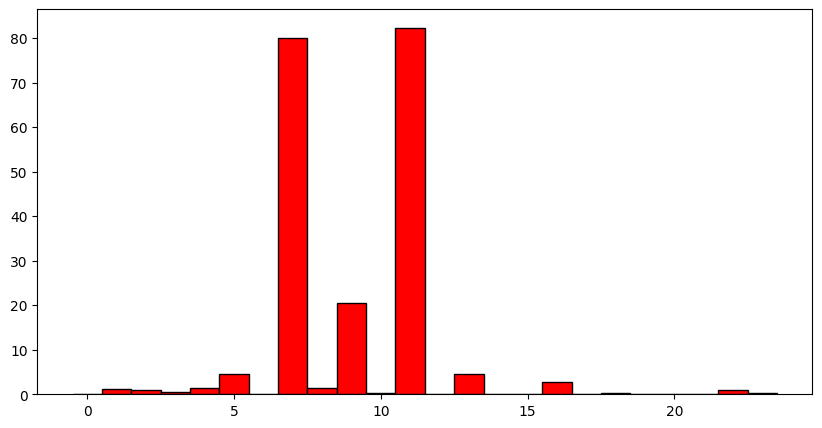

In [ ]:
mean_time_comparison_distortions(time_to_execute)

# Choosing distortions orders

Passing the indices of the distortions you want to combine through get_distortion's parameters limits the possible combinations.

In [ ]:
functions = [(distortions_dict[i], i) for i in range(len(choices)) if choices[i].value == True]
source_directory = "/content/drive/MyDrive/images/"
get_distortions(source_directory, '/content/drive/MyDrive/target/', functions, iterations.value, parameters, [[1,4], [4,17], [6,9]])

Writing on: /content/drive/MyDrive/target/
im_00.png
im_00_01_01.png
im_00_01_02.png
im_00_01_03.png
im_00_24_01.png
im_00_24_02.png
im_00_24_03.png
im_00_25_01.png
im_00_26_01.png
